In [1]:
# OBJECTIF 1 : prédire les émissions de CO2 (GHGEmissions) et la consommation totale d’énergie (SiteEnergyUse)
# d'un bâtiment sans utiliser de données du relevés de consommation

# OBJECTIF 2 : évaluer l'intérêt de l'ENERGY STAR SCORE pour la prédiction de ces valeurs

In [2]:
import pandas as pd
import numpy as np
import ast
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

In [3]:
#On charge les données de consommation de 2015 et 2016
data_2015 = pd.read_csv("data energie/2015-building-energy-benchmarking.csv")
data_2016 = pd.read_csv("data energie/2016-building-energy-benchmarking.csv")

In [4]:
#Liste des colonnes présente seulement dans le dataframe 2015 
data_2015.columns[~ data_2015.columns.isin(data_2016.columns)]

Index(['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'City Council Districts', 'SPD Beats', 'Zip Codes'],
      dtype='object')

In [5]:
#Liste des colonnes présente seulement dans le dataframe 2016
data_2016.columns[~ data_2016.columns.isin(data_2015.columns)]

Index(['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude',
       'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')

In [6]:
#On compare les tailles des dataframes
print("Taille du dataframe 2015 : ", data_2015.shape)
print("Taille du dataframe 2016 : ", data_2016.shape)

Taille du dataframe 2015 :  (3340, 47)
Taille du dataframe 2016 :  (3376, 46)


In [7]:
#On regarde le nombre de doublons
doublons = data_2015[data_2015['OSEBuildingID'].isin(data_2016['OSEBuildingID'].unique())].shape[0]
print("Nombre de doublons entre 2015 et 2016 : ", doublons)

Nombre de doublons entre 2015 et 2016 :  3284


In [8]:
#On observe la structure
data_2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,...,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,...,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,...,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [9]:
#On sépare la colonne location pour que le format soit similaire au dataframe de 2016
lat = []
lon = []
address = []
city = []
state = []
ZIP = []

#Pour chaque ligne, on sépare la latitude, la longitude, l'adresse, la ville, l'état et la code ZIP
for idx, row in data_2015.iterrows():
    data_dict = ast.literal_eval(row['Location'])
    lat.append(data_dict['latitude'])
    lon.append(data_dict['longitude'])
    human_adress = ast.literal_eval(data_dict['human_address'])
    address.append(human_adress['address'])
    city.append(human_adress['city'])
    state.append(human_adress['state'])
    ZIP.append(human_adress['zip'])

#On supprime la colonne Location et on en créé une par variable
data_2015.drop(columns="Location", inplace=True)
data_2015["Latitude"] = lat
data_2015["Longitude"] = lon
data_2015["Address"] = address
data_2015["City"] = city
data_2015["State"] = state
data_2015["ZipCode"] = ZIP

In [10]:
#Liste des colonnes présente seulement dans le dataframe 2015 
data_2015.columns[~ data_2015.columns.isin(data_2016.columns)]

Index(['OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'City Council Districts', 'SPD Beats', 'Zip Codes'],
      dtype='object')

In [11]:
#Liste des colonnes présente seulement dans le dataframe 2016
data_2016.columns[~ data_2016.columns.isin(data_2015.columns)]

Index(['Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity'], dtype='object')

In [12]:
#On renomme le noms des colonnes pour pouvoir faire une concatenation
data_2015.rename(columns={"GHGEmissionsIntensity(kgCO2e/ft2)": "GHGEmissionsIntensity"
                           ,"GHGEmissions(MetricTonsCO2e)": "TotalGHGEmissions"}, inplace=True)

In [13]:
#On supprime les colonnes que nous n'utiliserons pas pour la concatenation
data_2015.drop(columns=['Comment', '2010 Census Tracts'
                        ,'Seattle Police Department Micro Community Policing Plan Areas','City Council Districts'
                        , 'SPD Beats', 'Zip Codes'], inplace=True)
data_2016.drop(columns=['Comments'], inplace=True)

In [14]:
#On concatène les deux dataframes
data = pd.concat([data_2015, data_2016])
data.shape

(6716, 46)

In [15]:
#On supprime les doublons en gardant les valeurs les plus récentes
data = data.drop_duplicates(subset=['OSEBuildingID'], keep = 'last').sort_values(by='OSEBuildingID')

#On reinitialise les index
data = data.reset_index(drop=True)

#On change le type des colonnes Latitude et Longitude
data[['Latitude','Longitude','ZipCode']] = data[['Latitude','Longitude','ZipCode']].astype('float64')
data['CouncilDistrictCode'] = data['CouncilDistrictCode'].astype('object')

#On change le nom de certaines colonnes
data = data.rename(columns={'SiteEnergyUse(kBtu)': 'SiteEnergyUse'})

In [16]:
#On garde seulement les bâtiments non destinés à l’habitation
data = data[data['BuildingType'].isin(['NonResidential', 'Nonresidential COS','SPS-District K-12','Campus'])]

In [17]:
#La plupart de nos valeurs datent de 2016 car on a gardé les plus récentes
data['DataYear'].value_counts()

2016    1667
2015      30
Name: DataYear, dtype: int64

In [18]:
data.dtypes

OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
TaxParcelIdentificationNumber       object
CouncilDistrictCode                 object
Neighborhood                        object
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                     float64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLargestPropertyUseType        object
SecondLargestPropertyUseTypeGFA    float64
ThirdLargestPropertyUseType         object
ThirdLargestPropertyUseTypeGFA     float64
YearsENERGYSTARCertified            object
ENERGYSTARScore                    float64
SiteEUI(kBt

In [19]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,...,GHGEmissionsIntensity,DefaultData,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode
0,1,2016,NonResidential,Hotel,Mayflower park hotel,0659000030,7,DOWNTOWN,1927,1.0,...,2.83,False,Compliant,NaN,47.61220,-122.33799,405 Olive way,Seattle,WA,98101.0
1,2,2016,NonResidential,Hotel,Paramount Hotel,0659000220,7,DOWNTOWN,1996,1.0,...,2.86,False,Compliant,NaN,47.61317,-122.33393,724 Pine street,Seattle,WA,98101.0
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,0659000475,7,DOWNTOWN,1969,1.0,...,2.19,False,Compliant,NaN,47.61393,-122.33810,1900 5th Avenue,Seattle,WA,98101.0
3,5,2016,NonResidential,Hotel,HOTEL MAX,0659000640,7,DOWNTOWN,1926,1.0,...,4.67,False,Compliant,NaN,47.61412,-122.33664,620 STEWART ST,Seattle,WA,98101.0
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),0659000970,7,DOWNTOWN,1980,1.0,...,2.88,False,Compliant,NaN,47.61375,-122.34047,401 LENORA ST,Seattle,WA,98121.0



# Données générales
<br/> **OSEBuildingID** : ID unique
<br/> **DataYear** : Année de mesure des données
<br/> **'TaxParcelIdentificationNumber** :ID taxe

# Données déclaratives
<br/> **BuildingType** : Residential / Non residential
<br/> **PrimaryPropertyType** : Principale type de la propriété : College / Laboratory / ... / Other
<br/> **'PropertyName!** : Nom de la propriété
<br/> **YearBuilt** : de 1900 à 2015
<br/> **NumberofBuildings** : Nombre de batiments (de 1 à 39)
<br/> **NumberofFloors** : Nombre de batiments (de 1 à 99)
<br/> **PropertyGFATotal** : Somme des surfaces de chaque niveau, des surfaces des toitures-terrasses, des balcons et des surfaces non closes situées au rez-de-chaussée, y compris l’épaisseur des murs et des cloisons.
<br/> **PropertyGFAParking** : Somme des surfaces du parking
<br/> **PropertyGFABuilding(s)** : Somme des surfaces du/des batiment(s)


# Données géographiques
<br/> **CouncilDistrictCode** : District de 1 à 7
<br/> **Neighborhood** : Nom du quartier Ballard / Central
<br/> **Latitude** : Latitude
<br/> **Longitude** : Longitude
<br/> **Address** : Adresse
<br/> **City** : Ville
<br/> **State** : Etat du batiment
<br/> **ZipCode** : Code postal


## Données des relevés de consommation (fuite de données)
<br/> **YearsENERGYSTARCertified** : Années d'obtention de la certification ENERGY STAR
<br/> **ENERGYSTARScore** : Performance energetique du batiment (score entre 1 et 100)
<br/> **SiteEUI(kBtu/sf)** : Intensité d'utilisation de l'énergie de la propriété (kBtu/sf est un équivalent du KwH/m²)
<br/> **SiteEUIWN(kBtu/sf)** : similaire à siteEUI(kBtu/sf)
<br/> **SourceEUI(kBtu/sf)** : Intensité d'utilisation de l'énergie de la propriété depuis la source : production
transmission + perte (kBtu/sf est un équivalent du KwH/m²)
<br/> **SourceEUIWN(kBtu/sf)** : similaire à sourceEUI(kBtu/sf)
<br/> **SteamUse(kBtu)** : à creuser
<br/> **Electricity(kBtu)** : Consommation electricité en kBtu
<br/> **NaturalGas(kBtu)** : Consommation de gaz en kBtu
<br/> **OtherFuelUse(kBtu)** : Consommation des autres combustibles en kBtu


## Données cible
<br/> **SiteEnergyUse(kBtu)** : Consommation de la propriété en kBtu (KwH)
<br/> **SiteEnergyUseWN(kBtu)** : similaire à SiteEnergyUse(kBtu)
<br/> **GHGEmissionsIntensity(kgCO2e/ft2)** : Intensité d'émission des gazs à effet de serre (en kG de CO2 par foot au carré)
<br/> **GHGEmissions(MetricTonsCO2e)** : Emission des gazs à effet de serre (en tonnes de CO2)

In [20]:
#On souhaite créer des modèles qui se passent des données de consommation, on les retire de notre dataframe
#On garde seulement les variables cibles 'TotalGHGEmissions','SiteEnergyUse' et 'ENERGYSTARScore'
data_opt = data[['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType','CouncilDistrictCode','Neighborhood',
                 'Latitude', 'Longitude','YearBuilt', 'NumberofBuildings','NumberofFloors','PropertyGFATotal',
                 'PropertyGFAParking', 'PropertyGFABuilding(s)','LargestPropertyUseTypeGFA','ENERGYSTARScore',
                 'TotalGHGEmissions','SiteEnergyUse']]

In [21]:
#On liste les valeurs nulles par colonnes
data_opt.isnull().sum()

OSEBuildingID                  0
BuildingType                   0
PrimaryPropertyType            0
CouncilDistrictCode            0
Neighborhood                   0
Latitude                       0
Longitude                      0
YearBuilt                      0
NumberofBuildings              2
NumberofFloors                 0
PropertyGFATotal               0
PropertyGFAParking             0
PropertyGFABuilding(s)         0
LargestPropertyUseTypeGFA     12
ENERGYSTARScore              585
TotalGHGEmissions              3
SiteEnergyUse                  3
dtype: int64

In [22]:
#On supprime les lignes ayant des valeurs nulles
data_opt = data_opt.dropna()

In [23]:
#Notre dataframe est maintenant prêt à être analysé 
data_opt.notnull().sum()

OSEBuildingID                1107
BuildingType                 1107
PrimaryPropertyType          1107
CouncilDistrictCode          1107
Neighborhood                 1107
Latitude                     1107
Longitude                    1107
YearBuilt                    1107
NumberofBuildings            1107
NumberofFloors               1107
PropertyGFATotal             1107
PropertyGFAParking           1107
PropertyGFABuilding(s)       1107
LargestPropertyUseTypeGFA    1107
ENERGYSTARScore              1107
TotalGHGEmissions            1107
SiteEnergyUse                1107
dtype: int64

In [24]:
#On créé le dataframe qu'on va utiliser pour notre analyse exploratoire
data_exploration = data_opt.copy()

In [25]:
#On enlève les valeurs aberrantes 
Q1 = data_exploration[['PropertyGFATotal']].quantile(0.25)[0]
Q3 = data_exploration[['PropertyGFATotal']].quantile(0.75)[0]
IQR = Q3 - Q1
data_exploration = data_exploration[data_exploration['PropertyGFATotal'] < Q3 + IQR * 1.5]

In [26]:
#On enlève les valeurs aberrantes 
Q1 = data_exploration[['NumberofFloors']].quantile(0.25)[0]
Q3 = data_exploration[['NumberofFloors']].quantile(0.75)[0]
IQR = Q3 - Q1
data_exploration = data_exploration[data_exploration['NumberofFloors'] < Q3 + IQR * 1.5]

In [27]:
#On enlève les valeurs aberrantes 
Q1 = data_exploration[['LargestPropertyUseTypeGFA']].quantile(0.25)[0]
Q3 = data_exploration[['LargestPropertyUseTypeGFA']].quantile(0.75)[0]
IQR = Q3 - Q1
data_exploration = data_exploration[data_exploration['LargestPropertyUseTypeGFA'] < Q3 + IQR * 1.5]

In [28]:
#On enlève les valeurs aberrantes 
Q1 = data_exploration[['TotalGHGEmissions']].quantile(0.25)[0]
Q3 = data_exploration[['TotalGHGEmissions']].quantile(0.75)[0]
IQR = Q3 - Q1
data_exploration = data_exploration[data_exploration['TotalGHGEmissions'] < Q3 + IQR * 1.5]

In [29]:
#On enlève les valeurs aberrantes 
Q1 = data_exploration[['SiteEnergyUse']].quantile(0.25)[0]
Q3 = data_exploration[['SiteEnergyUse']].quantile(0.75)[0]
IQR = Q3 - Q1
data_exploration = data_exploration[data_exploration['SiteEnergyUse'] < Q3 + IQR * 1.5]

<br/>
<br/>

# Analyse variable qualitative (ANOVA)

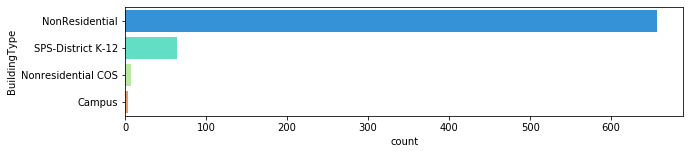

In [30]:
#On observe le nombre d'observations par catégorie
fig, ax = plt.subplots(figsize=(10,2))
graph = sns.countplot(y='BuildingType', ax=ax, data=data_exploration
                     ,palette='rainbow', order = data_exploration['BuildingType'].value_counts().index)

Text(0.5, 1.0, 'Boxplot BuildingType')

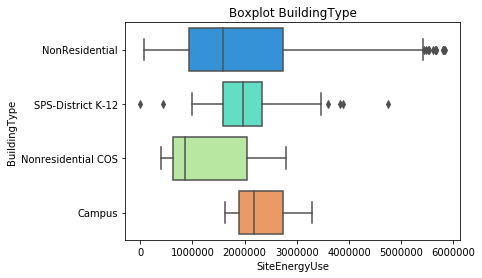

In [31]:
#On observe les boxplot par catégorie (pour la variable cible SiteEnergyUse)
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(x='SiteEnergyUse',y = 'BuildingType', ax=ax, data=data_exploration, orient="h"
            ,palette='rainbow', order = data_exploration['BuildingType'].value_counts().index)
plt.title("Boxplot BuildingType")

Text(0.5, 1.0, 'Boxplot BuildingType')

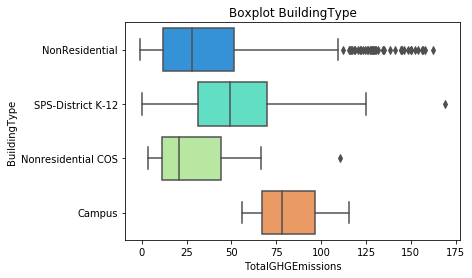

In [32]:
#On observe les boxplot par catégorie (pour la variable cible TotalGHGEmissions)
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(x='TotalGHGEmissions',y = 'BuildingType', ax=ax, data=data_exploration, orient="h"
            ,palette='rainbow', order = data_exploration['BuildingType'].value_counts().index)
plt.title("Boxplot BuildingType")

In [33]:
#On effectue une ANOVA sur le type de batiment (pour SiteEnergyUse)
anova_BuildingType = smf.ols('SiteEnergyUse~BuildingType', data=data_exploration).fit()
print(anova_BuildingType.summary())

                            OLS Regression Results                            
Dep. Variable:          SiteEnergyUse   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6957
Date:                Tue, 20 Apr 2021   Prob (F-statistic):              0.555
Time:                        15:50:59   Log-Likelihood:                -11322.
No. Observations:                 730   AIC:                         2.265e+04
Df Residuals:                     726   BIC:                         2.267e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [34]:
#Test de Fisher : on a une p-value égale à 0.55 (>5%)
sm.stats.anova_lm(anova_BuildingType, typ=2)

,sum_sq,df,F,PR(>F)
BuildingType,3.639295e+12,3.0,0.695732,0.554824
Residual,1.265874e+15,726.0,NaN,NaN


In [35]:
#On effectue une ANOVA sur le type de batiment (pour TotalGHGEmissions)
anova_BuildingType_GHG = smf.ols('TotalGHGEmissions~BuildingType', data=data_exploration).fit()
print(anova_BuildingType_GHG.summary())

                            OLS Regression Results                            
Dep. Variable:      TotalGHGEmissions   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     5.336
Date:                Tue, 20 Apr 2021   Prob (F-statistic):            0.00122
Time:                        15:50:59   Log-Likelihood:                -3626.4
No. Observations:                 730   AIC:                             7261.
Df Residuals:                     726   BIC:                             7279.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [36]:
#Test de Fisher : on a une p-value égale à 0.0012 (<5%)
sm.stats.anova_lm(anova_BuildingType_GHG, typ=2)

,sum_sq,df,F,PR(>F)
BuildingType,19462.014097,3.0,5.336234,0.00122
Residual,882608.795950,726.0,NaN,NaN


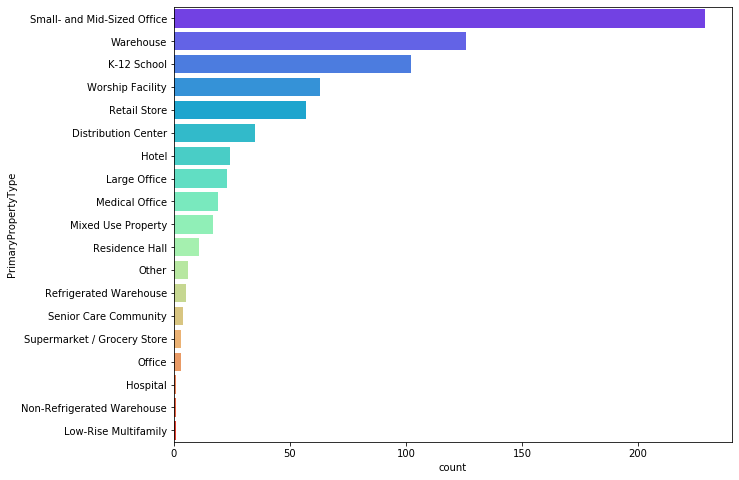

In [37]:
#On observe le nombre d'observations par catégorie
fig, ax = plt.subplots(figsize=(10,8))
graph = sns.countplot(y='PrimaryPropertyType', ax=ax, data=data_exploration 
                      ,palette='rainbow', order = data_exploration['PrimaryPropertyType'].value_counts().index)

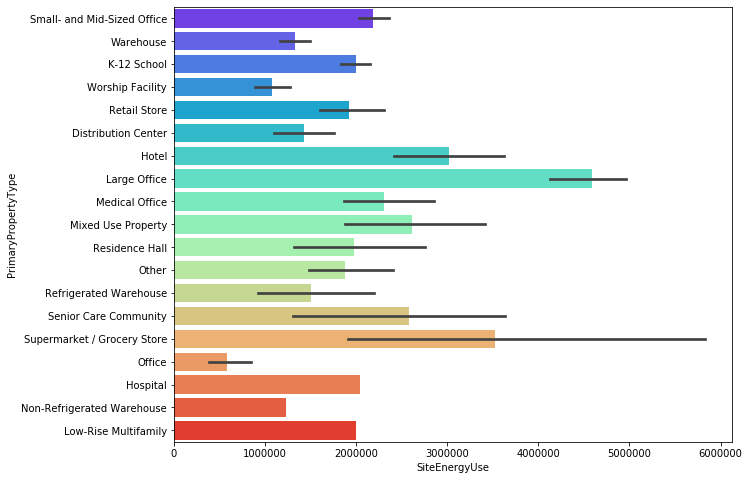

In [38]:
#On observe SiteEnergyUse par catégorie
fig, ax = plt.subplots(figsize=(10,8))
graph = sns.barplot(y='PrimaryPropertyType',x='SiteEnergyUse', ax=ax, data=data_exploration
                   ,palette='rainbow', order = data_exploration['PrimaryPropertyType'].value_counts().index)

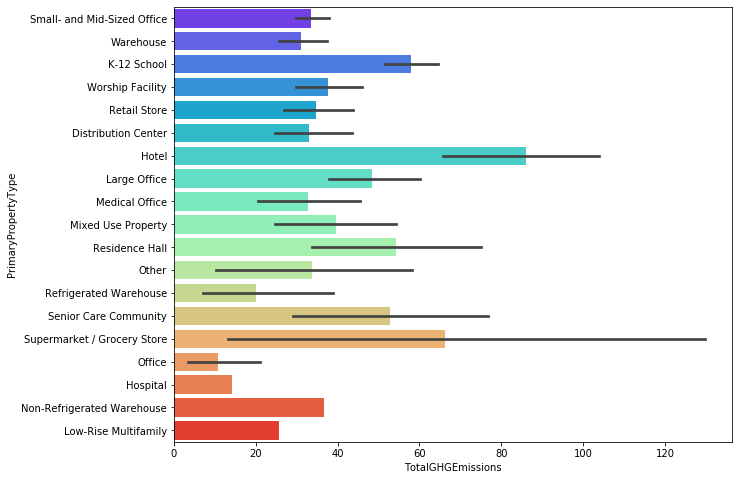

In [39]:
#On observe TotalGHGEmissions par catégorie
fig, ax = plt.subplots(figsize=(10,8))
graph = sns.barplot(y='PrimaryPropertyType',x='TotalGHGEmissions', ax=ax, data=data_exploration
                   ,palette='rainbow', order = data_exploration['PrimaryPropertyType'].value_counts().index)

Text(0.5, 1.0, 'Boxplot PrimaryPropertyType')

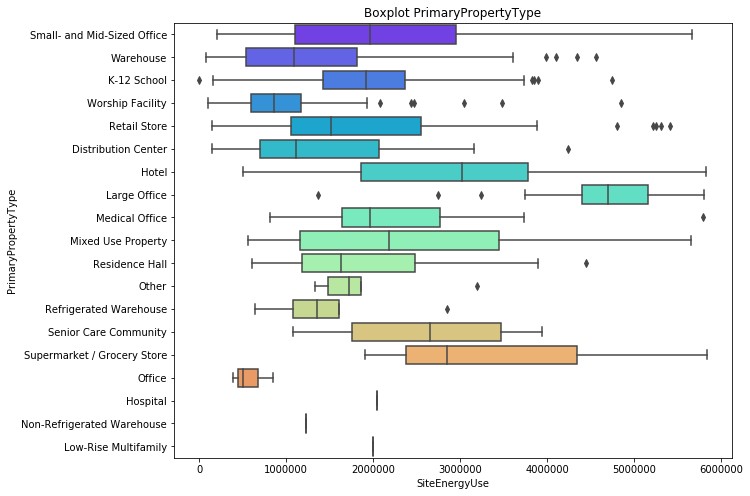

In [40]:
#On observe les boxplot par catégorie (pour la variable cible SiteEnergyUse)
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x='SiteEnergyUse',y = 'PrimaryPropertyType', ax=ax, data=data_exploration, orient="h"
            ,palette='rainbow', order = data_exploration['PrimaryPropertyType'].value_counts().index)
plt.title("Boxplot PrimaryPropertyType")

Text(0.5, 1.0, 'Boxplot PrimaryPropertyType')

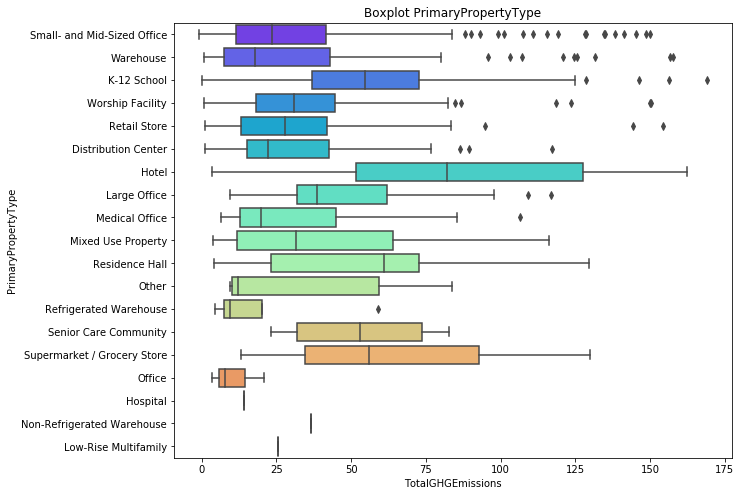

In [41]:
#On observe les boxplot par catégorie (pour la variable cible TotalGHGEmissions)
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x='TotalGHGEmissions',y = 'PrimaryPropertyType', ax=ax, data=data_exploration, orient="h"
            ,palette='rainbow', order = data_exploration['PrimaryPropertyType'].value_counts().index)
plt.title("Boxplot PrimaryPropertyType")

In [42]:
#On effectue une ANOVA sur le type de propriété (pour SiteEnergyUse)
anova_PrimaryPropertyType = smf.ols('SiteEnergyUse~PrimaryPropertyType', data=data_exploration).fit()
print(anova_PrimaryPropertyType.summary())

                            OLS Regression Results                            
Dep. Variable:          SiteEnergyUse   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     14.03
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           2.01e-36
Time:                        15:51:02   Log-Likelihood:                -11212.
No. Observations:                 730   AIC:                         2.246e+04
Df Residuals:                     711   BIC:                         2.255e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [43]:
#Test de Fisher : on a une p-value égale à 2.008324e-36 (<5%)
sm.stats.anova_lm(anova_PrimaryPropertyType, typ=2)

,sum_sq,df,F,PR(>F)
PrimaryPropertyType,3.326808e+14,18.0,14.026938,2.008324e-36
Residual,9.368326e+14,711.0,NaN,NaN


In [44]:
#On effectue une ANOVA sur le type de propriété (pour TotalGHGEmissions)
anova_PrimaryPropertyType_GHG = smf.ols('TotalGHGEmissions~PrimaryPropertyType', data=data_exploration).fit()
print(anova_PrimaryPropertyType_GHG.summary())

                            OLS Regression Results                            
Dep. Variable:      TotalGHGEmissions   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     6.039
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           8.49e-14
Time:                        15:51:02   Log-Likelihood:                -3582.5
No. Observations:                 730   AIC:                             7203.
Df Residuals:                     711   BIC:                             7290.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [45]:
#Test de Fisher : on a une p-value égale à 2.008324e-36 (<5%)
sm.stats.anova_lm(anova_PrimaryPropertyType_GHG, typ=2)

,sum_sq,df,F,PR(>F)
PrimaryPropertyType,119617.775570,18.0,6.038576,8.492413e-14
Residual,782453.034477,711.0,NaN,NaN


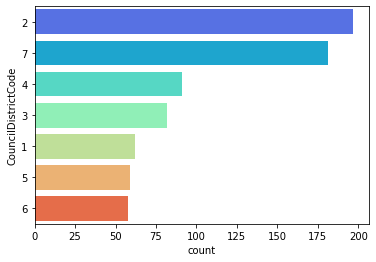

In [46]:
#On observe le nombre d'observations par catégorie
fig, ax = plt.subplots(figsize=(6,4))
graph = sns.countplot(y='CouncilDistrictCode', ax=ax, data=data_exploration 
                      ,palette='rainbow', order = data_exploration['CouncilDistrictCode'].value_counts().index)

Text(0.5, 1.0, 'Boxplot CouncilDistrictCode')

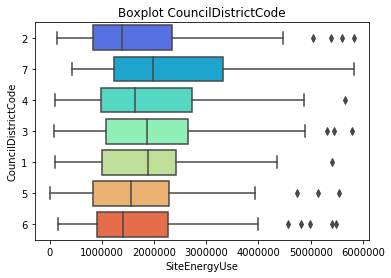

In [47]:
#On observe les boxplot par catégorie (pour la variable cible SiteEnergyUse)
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(x='SiteEnergyUse',y = 'CouncilDistrictCode', ax=ax, data=data_exploration, orient="h"
            ,palette='rainbow', order = data_exploration['CouncilDistrictCode'].value_counts().index)
plt.title("Boxplot CouncilDistrictCode")

Text(0.5, 1.0, 'Boxplot CouncilDistrictCode')

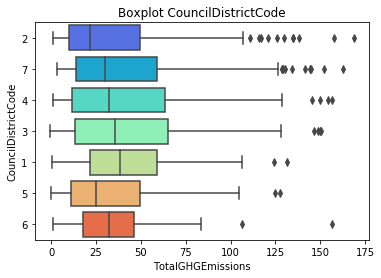

In [48]:
#On observe les boxplot par catégorie (pour la variable cible TotalGHGEmissions)
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(x='TotalGHGEmissions',y = 'CouncilDistrictCode', ax=ax, data=data_exploration, orient="h"
            ,palette='rainbow', order = data_exploration['CouncilDistrictCode'].value_counts().index)
plt.title("Boxplot CouncilDistrictCode")

In [49]:
#On effectue une ANOVA sur le type de district (pour SiteEnergyUse)
anova_CouncilDistrictCode = smf.ols('SiteEnergyUse~CouncilDistrictCode', data=data_exploration).fit()
print(anova_CouncilDistrictCode.summary())

                            OLS Regression Results                            
Dep. Variable:          SiteEnergyUse   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     5.005
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           4.88e-05
Time:                        15:51:03   Log-Likelihood:                -11308.
No. Observations:                 730   AIC:                         2.263e+04
Df Residuals:                     723   BIC:                         2.266e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [50]:
#Test de Fisher : on a une p-value égale à 0.000049 (<5%)
sm.stats.anova_lm(anova_CouncilDistrictCode, typ=2)

,sum_sq,df,F,PR(>F)
CouncilDistrictCode,5.062874e+13,6.0,5.005202,0.000049
Residual,1.218885e+15,723.0,NaN,NaN


In [51]:
#On effectue une ANOVA sur le type de district (pour TotalGHGEmissions)
anova_CouncilDistrictCode_GHG = smf.ols('TotalGHGEmissions~CouncilDistrictCode', data=data_exploration).fit()
print(anova_CouncilDistrictCode_GHG.summary())

                            OLS Regression Results                            
Dep. Variable:      TotalGHGEmissions   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.610
Date:                Tue, 20 Apr 2021   Prob (F-statistic):              0.142
Time:                        15:51:03   Log-Likelihood:                -3629.6
No. Observations:                 730   AIC:                             7273.
Df Residuals:                     723   BIC:                             7305.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [52]:
#Test de Fisher : on a une p-value égale à 0.141603 (>5%)
sm.stats.anova_lm(anova_CouncilDistrictCode_GHG, typ=2)

,sum_sq,df,F,PR(>F)
CouncilDistrictCode,11890.318067,6.0,1.609542,0.141603
Residual,890180.491980,723.0,NaN,NaN


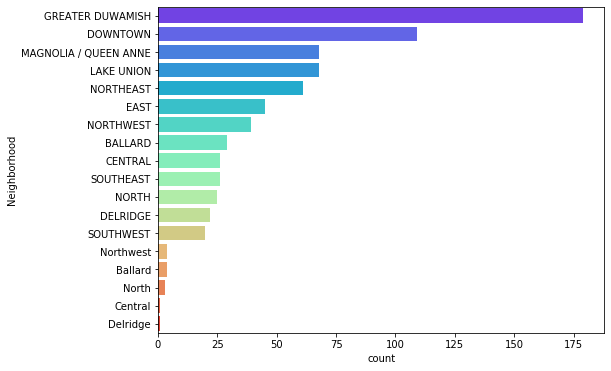

In [53]:
#On observe le nombre d'observations par catégorie
fig, ax = plt.subplots(figsize=(8,6))
graph = sns.countplot(y='Neighborhood', ax=ax, data=data_exploration 
                      ,palette='rainbow', order = data_exploration['Neighborhood'].value_counts().index)

Text(0.5, 1.0, 'Boxplot Neighborhood')

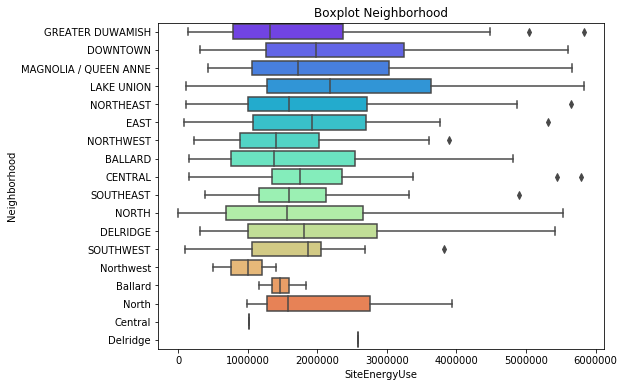

In [54]:
#On observe les boxplot par catégorie (pour la variable cible SiteEnergyUse)
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(x='SiteEnergyUse',y = 'Neighborhood', ax=ax, data=data_exploration, orient="h"
            ,palette='rainbow', order = data_exploration['Neighborhood'].value_counts().index)
plt.title("Boxplot Neighborhood")

Text(0.5, 1.0, 'Boxplot Neighborhood')

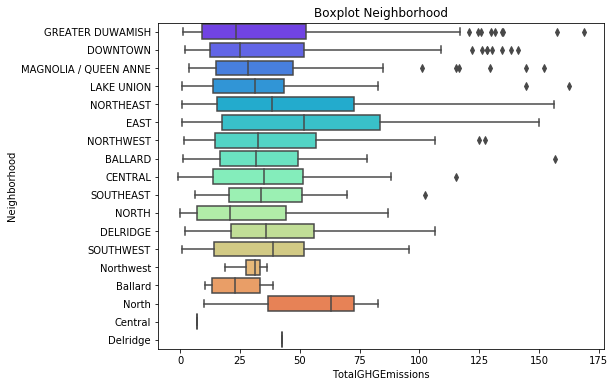

In [55]:
#On observe les boxplot par catégorie (pour la variable cible TotalGHGEmissions)
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(x='TotalGHGEmissions',y = 'Neighborhood', ax=ax, data=data_exploration, orient="h"
            ,palette='rainbow', order = data_exploration['Neighborhood'].value_counts().index)
plt.title("Boxplot Neighborhood")

In [56]:
#On effectue une ANOVA sur le type de quartier (pour SiteEnergyUse)
anova_Neighborhood = smf.ols('SiteEnergyUse~Neighborhood', data=data_exploration).fit()
print(anova_Neighborhood.summary())

                            OLS Regression Results                            
Dep. Variable:          SiteEnergyUse   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.723
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           0.000218
Time:                        15:51:04   Log-Likelihood:                -11300.
No. Observations:                 730   AIC:                         2.264e+04
Df Residuals:                     712   BIC:                         2.272e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [57]:
#Test de Fisher : on a une p-value égale à 0.000218 (<5%)
sm.stats.anova_lm(anova_Neighborhood, typ=2)

,sum_sq,df,F,PR(>F)
Neighborhood,7.750216e+13,17.0,2.723106,0.000218
Residual,1.192011e+15,712.0,NaN,NaN


In [58]:
#On effectue une ANOVA sur le type de quartier (pour TotalGHGEmissions)
anova_Neighborhood_GHG = smf.ols('TotalGHGEmissions~Neighborhood', data=data_exploration).fit()
print(anova_Neighborhood_GHG.summary())

                            OLS Regression Results                            
Dep. Variable:      TotalGHGEmissions   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.544
Date:                Tue, 20 Apr 2021   Prob (F-statistic):             0.0736
Time:                        15:51:05   Log-Likelihood:                -3621.2
No. Observations:                 730   AIC:                             7278.
Df Residuals:                     712   BIC:                             7361.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [59]:
#Test de Fisher : on a une p-value égale à 0.073608 (>5%)
sm.stats.anova_lm(anova_Neighborhood_GHG, typ=2)

,sum_sq,df,F,PR(>F)
Neighborhood,32074.034817,17.0,1.54407,0.073608
Residual,869996.775230,712.0,NaN,NaN


# Analyse variable quantitative (corrélation Pearson / Spearman)

Moyenne:  2.52  Mediane:  2.0  Mode:  1.0  Variance:  2.36  Ecart-type:  1.54


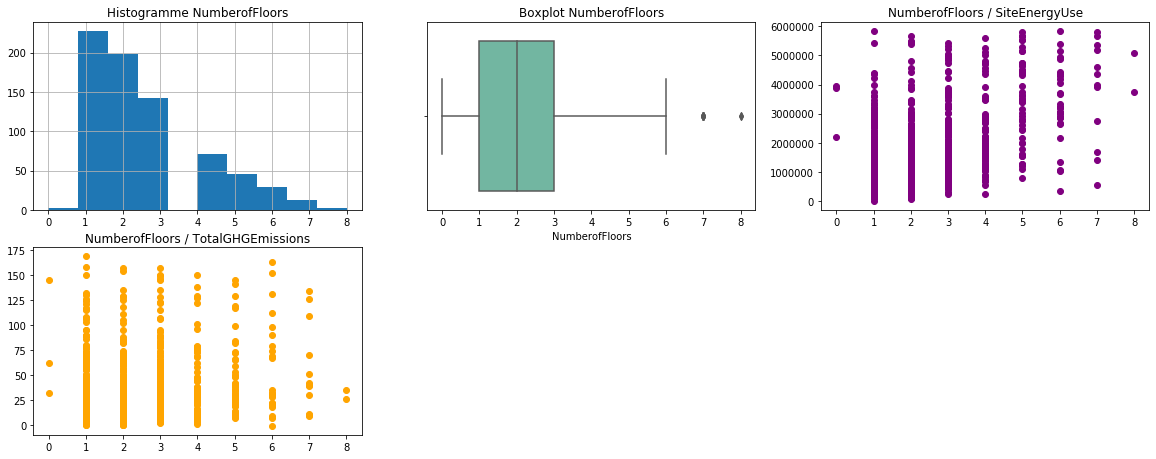

In [60]:
#On observe l'histogramme, le boxplot et le nuage de points par rapport aux variables cibles
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(5,3,1)
data_exploration["NumberofFloors"].hist()
plt.title("Histogramme NumberofFloors")
ax = fig.add_subplot(5,3,2)
sns.boxplot(x = 'NumberofFloors', data=data_exploration, orient="h", palette="Set2")
plt.title("Boxplot NumberofFloors")
ax = fig.add_subplot(5,3,3)
plt.scatter(data_exploration["NumberofFloors"], data_exploration["SiteEnergyUse"], color="purple")
plt.title("NumberofFloors / SiteEnergyUse")
ax = fig.add_subplot(5,3,4)
plt.scatter(data_exploration["NumberofFloors"], data_exploration["TotalGHGEmissions"], color="orange")
plt.title("NumberofFloors / TotalGHGEmissions")

print("Moyenne: ", round(data_exploration["NumberofFloors"].mean(),2)
     ," Mediane: ", round(data_exploration["NumberofFloors"].median(),2)
     ," Mode: ", round(data_exploration["NumberofFloors"].mode()[0],2)
     ," Variance: ", round(data_exploration["NumberofFloors"].var(),2)
     ," Ecart-type: ", round(data_exploration["NumberofFloors"].std(),2))

Moyenne:  49181.19  Mediane:  39787.5  Mode:  25920  Variance:  948781487.17  Ecart-type:  30802.3


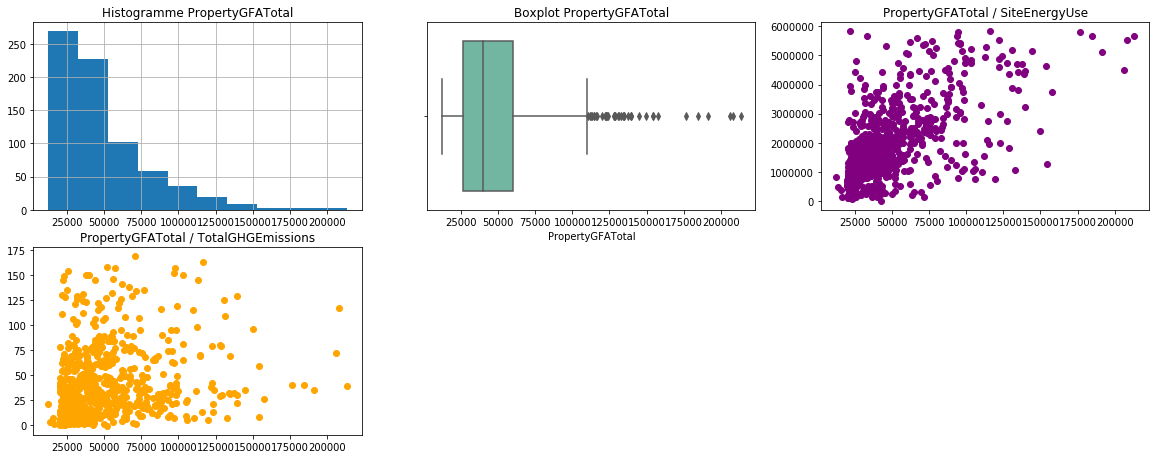

In [61]:
#On observe l'histogramme, le boxplot et le nuage de points par rapport aux variables cibles
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(5,3,1)
data_exploration["PropertyGFATotal"].hist()
plt.title("Histogramme PropertyGFATotal")
ax = fig.add_subplot(5,3,2)
sns.boxplot(x = 'PropertyGFATotal', data=data_exploration, orient="h", palette="Set2")
plt.title("Boxplot PropertyGFATotal")
ax = fig.add_subplot(5,3,3)
plt.scatter(data_exploration["PropertyGFATotal"], data_exploration["SiteEnergyUse"], color="purple")
plt.title("PropertyGFATotal / SiteEnergyUse")
ax = fig.add_subplot(5,3,4)
plt.scatter(data_exploration["PropertyGFATotal"], data_exploration["TotalGHGEmissions"], color="orange")
plt.title("PropertyGFATotal / TotalGHGEmissions")

print("Moyenne: ", round(data_exploration["PropertyGFATotal"].mean(),2)
     ," Mediane: ", round(data_exploration["PropertyGFATotal"].median(),2)
     ," Mode: ", round(data_exploration["PropertyGFATotal"].mode()[0],2)
     ," Variance: ", round(data_exploration["PropertyGFATotal"].var(),2)
     ," Ecart-type: ", round(data_exploration["PropertyGFATotal"].std(),2))

In [ ]:
#On observe l'histogramme, le boxplot et le nuage de points par rapport aux variables cibles
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(5,3,1)
data_exploration["LargestPropertyUseTypeGFA"].hist()
plt.title("Histogramme LargestPropertyUseTypeGFA")
ax = fig.add_subplot(5,3,2)
sns.boxplot(x = 'LargestPropertyUseTypeGFA', data=data_exploration, orient="h", palette="Set2")
plt.title("Boxplot LargestPropertyUseTypeGFA")
ax = fig.add_subplot(5,3,3)
plt.scatter(data_exploration["LargestPropertyUseTypeGFA"], data_exploration["SiteEnergyUse"], color="purple")
plt.title("LargestPropertyUseTypeGFA / SiteEnergyUse")
ax = fig.add_subplot(5,3,4)
plt.scatter(data_exploration["LargestPropertyUseTypeGFA"], data_exploration["TotalGHGEmissions"], color="orange")
plt.title("LargestPropertyUseTypeGFA / TotalGHGEmissions")

print("Moyenne: ", round(data_exploration["LargestPropertyUseTypeGFA"].mean(),2)
     ," Mediane: ", round(data_exploration["LargestPropertyUseTypeGFA"].median(),2)
     ," Mode: ", round(data_exploration["LargestPropertyUseTypeGFA"].mode()[0],2)
     ," Variance: ", round(data_exploration["LargestPropertyUseTypeGFA"].var(),2)
     ," Ecart-type: ", round(data_exploration["LargestPropertyUseTypeGFA"].std(),2))

Moyenne:  43130.5  Mediane:  35636.5  Mode:  30000.0  Variance:  608113533.46  Ecart-type:  24659.96


In [ ]:
#On observe l'histogramme, le boxplot et le nuage de points par rapport aux variables cibles
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(5,3,1)
data_exploration["NumberofFloors"].hist()
plt.title("Histogramme NumberofFloors")
ax = fig.add_subplot(5,3,2)
sns.boxplot(x = 'NumberofFloors', data=data_exploration, orient="h", palette="Set2")
plt.title("Boxplot NumberofFloors")
ax = fig.add_subplot(5,3,3)
plt.scatter(data_exploration["NumberofFloors"], data_exploration["SiteEnergyUse"], color="purple")
plt.title("NumberofFloors / SiteEnergyUse")
ax = fig.add_subplot(5,3,4)
plt.scatter(data_exploration["NumberofFloors"], data_exploration["TotalGHGEmissions"], color="orange")
plt.title("NumberofFloors / TotalGHGEmissions")

print("Moyenne: ", round(data_exploration["NumberofFloors"].mean(),2)
     ," Mediane: ", round(data_exploration["NumberofFloors"].median(),2)
     ," Mode: ", round(data_exploration["NumberofFloors"].mode()[0],2)
     ," Variance: ", round(data_exploration["NumberofFloors"].var(),2)
     ," Ecart-type: ", round(data_exploration["NumberofFloors"].std(),2))

In [ ]:
#On observe l'histogramme, le boxplot et le nuage de points par rapport aux variables cibles
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(5,3,1)
data_exploration["Latitude"].hist()
plt.title("Histogramme Latitude")
ax = fig.add_subplot(5,3,2)
sns.boxplot(x = 'Latitude', data=data_exploration, orient="h", palette="Set2")
plt.title("Boxplot Latitude")
ax = fig.add_subplot(5,3,3)
plt.scatter(data_exploration["Latitude"], data_exploration["SiteEnergyUse"], color="purple")
plt.title("Latitude / SiteEnergyUse")
ax = fig.add_subplot(5,3,4)
plt.scatter(data_exploration["Latitude"], data_exploration["TotalGHGEmissions"], color="orange")
plt.title("Latitude / TotalGHGEmissions")

print("Moyenne: ", round(data_exploration["Latitude"].mean(),2)
     ," Mediane: ", round(data_exploration["Latitude"].median(),2)
     ," Mode: ", round(data_exploration["Latitude"].mode()[0],2)
     ," Variance: ", round(data_exploration["Latitude"].var(),2)
     ," Ecart-type: ", round(data_exploration["Latitude"].std(),2))

In [ ]:
#On observe l'histogramme, le boxplot et le nuage de points par rapport aux variables cibles
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(5,3,1)
data_exploration["Longitude"].hist()
plt.title("Histogramme Longitude")
ax = fig.add_subplot(5,3,2)
sns.boxplot(x = 'Longitude', data=data_exploration, orient="h", palette="Set2")
plt.title("Boxplot Longitude")
ax = fig.add_subplot(5,3,3)
plt.scatter(data_exploration["Longitude"], data_exploration["SiteEnergyUse"], color="purple")
plt.title("Longitude / SiteEnergyUse")
ax = fig.add_subplot(5,3,4)
plt.scatter(data_exploration["Longitude"], data_exploration["TotalGHGEmissions"], color="orange")
plt.title("Longitude / TotalGHGEmissions")

print("Moyenne: ", round(data_exploration["Longitude"].mean(),2)
     ," Mediane: ", round(data_exploration["Longitude"].median(),2)
     ," Mode: ", round(data_exploration["Longitude"].mode()[0],2)
     ," Variance: ", round(data_exploration["Longitude"].var(),2)
     ," Ecart-type: ", round(data_exploration["Longitude"].std(),2))

In [ ]:
#A#On observe l'histogramme, le boxplot et le nuage de points par rapport aux variables cibles
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(5,3,1)
data_exploration["TotalGHGEmissions"].hist()
plt.title("Histogramme TotalGHGEmissions")
ax = fig.add_subplot(5,3,2)
sns.boxplot(x = 'TotalGHGEmissions', data=data_exploration, orient="h", palette="Set2")
plt.title("Boxplot TotalGHGEmissions")
ax = fig.add_subplot(5,3,3)
plt.scatter(data_exploration["TotalGHGEmissions"], data_exploration["SiteEnergyUse"], color="purple")
plt.title("TotalGHGEmissions / SiteEnergyUse")
ax = fig.add_subplot(5,3,4)
plt.scatter(data_exploration["TotalGHGEmissions"], data_exploration["TotalGHGEmissions"], color="orange")
plt.title("TotalGHGEmissions / TotalGHGEmissions")

print("Moyenne: ", round(data_exploration["TotalGHGEmissions"].mean(),2)
     ," Mediane: ", round(data_exploration["TotalGHGEmissions"].median(),2)
     ," Mode: ", round(data_exploration["TotalGHGEmissions"].mode()[0],2)
     ," Variance: ", round(data_exploration["TotalGHGEmissions"].var(),2)
     ," Ecart-type: ", round(data_exploration["TotalGHGEmissions"].std(),2))

In [ ]:
#On observe l'histogramme, le boxplot et le nuage de points par rapport aux variables cibles
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(5,3,1)
data_exploration["SiteEnergyUse"].hist()
plt.title("Histogramme SiteEnergyUse")
ax = fig.add_subplot(5,3,2)
sns.boxplot(x = 'SiteEnergyUse', data=data_exploration, orient="h", palette="Set2")
plt.title("Boxplot SiteEnergyUse")
ax = fig.add_subplot(5,3,3)
plt.scatter(data_exploration["SiteEnergyUse"], data_exploration["SiteEnergyUse"], color="purple")
plt.title("SiteEnergyUse / SiteEnergyUse")
ax = fig.add_subplot(5,3,4)
plt.scatter(data_exploration["SiteEnergyUse"], data_exploration["TotalGHGEmissions"], color="orange")
plt.title("SiteEnergyUse / TotalGHGEmissions")

print("Moyenne: ", round(data_exploration["SiteEnergyUse"].mean(),2)
     ," Mediane: ", round(data_exploration["SiteEnergyUse"].median(),2)
     ," Mode: ", round(data_exploration["SiteEnergyUse"].mode()[0],2)
     ," Variance: ", round(data_exploration["SiteEnergyUse"].var(),2)
     ," Ecart-type: ", round(data_exploration["SiteEnergyUse"].std(),2))

In [ ]:
# On trace notre matrice de corrélation
data_corr = data_opt[['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)','NumberofFloors',
                  'LargestPropertyUseTypeGFA', 'Latitude', 'Longitude','YearBuilt', 'ENERGYSTARScore'
                      , 'TotalGHGEmissions', 'SiteEnergyUse']]


fig = plt.figure(figsize=(80,80))
ax = fig.add_subplot(10,10,1)
sns.heatmap(data_corr.corr(), annot=True, ax = ax, cmap="Reds")

ax = fig.add_subplot(10,10,3)
sns.heatmap(data_corr.corr(method='spearman'), annot=True, ax = ax, cmap="Reds")

In [ ]:
#On trace notre nuage de point par rapport à la variable cible SiteEnergyUse
sns.pairplot(data_corr, x_vars =['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)','NumberofFloors',
                  'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'Latitude', 'Longitude','YearBuilt'], y_vars=["SiteEnergyUse"])

In [ ]:
#On trace notre nuage de point par rapport à la variable cible TotalGHGEmissions
sns.pairplot(data_corr, x_vars =['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)','NumberofFloors',
                  'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'Latitude', 'Longitude','YearBuilt'], y_vars=["TotalGHGEmissions"])

In [ ]:
#On observe la distribution des variables
sns.jointplot(x="PropertyGFATotal", y="SiteEnergyUse", data=data_corr,
                  kind="reg", truncate=False,
                  color="m", height=5)
sns.jointplot(x="PropertyGFATotal", y="TotalGHGEmissions", data=data_corr,
                  kind="reg", truncate=False,
                  color="m", height=5)

In [ ]:
#On créé un dataframe pour passer les variables ayant une trop grande amplitude au log
data_corr_log = data_corr.copy()

In [ ]:
#On supprime ou remplace les valeurs négatives ou nulles puis on les passe au log
data_corr_log.loc[data_corr_log['PropertyGFAParking'] <= 0, 'PropertyGFAParking'] = min(data_corr_log[data_corr_log['PropertyGFAParking'] > 0]['PropertyGFAParking'])
data_corr_log.loc[data_corr_log['NumberofFloors'] <= 0, 'NumberofFloors'] = min(data_corr_log[data_corr_log['NumberofFloors'] > 0]['NumberofFloors'])
data_corr_log = data_corr_log.loc[data_corr_log['SiteEnergyUse'] > 0]
data_corr_log = data_corr_log.loc[data_corr_log['TotalGHGEmissions'] > 0]


data_corr_log.loc[:,'PropertyGFATotal'] = np.log(data_corr_log['PropertyGFATotal'])
data_corr_log.loc[:,'PropertyGFAParking'] = np.log(data_corr_log['PropertyGFAParking'])
data_corr_log.loc[:,'PropertyGFABuilding(s)'] = np.log(data_corr_log['PropertyGFABuilding(s)'])
data_corr_log.loc[:,'NumberofFloors'] = np.log(data_corr_log['NumberofFloors'])
data_corr_log.loc[:,'LargestPropertyUseTypeGFA'] = np.log(data_corr_log['LargestPropertyUseTypeGFA'])
data_corr_log.loc[:,'Latitude'] = np.log(data_corr_log['Latitude'])
data_corr_log.loc[:,'ENERGYSTARScore'] = np.log(data_corr_log['ENERGYSTARScore'])
data_corr_log.loc[:,'SiteEnergyUse'] = np.log(data_corr_log['SiteEnergyUse'])
data_corr_log.loc[:,'TotalGHGEmissions'] = np.log(data_corr_log['TotalGHGEmissions'])



In [ ]:
# On trace notre matrice de corrélation avec nos valeurs passées au log
fig = plt.figure(figsize=(80,80))
ax = fig.add_subplot(10,10,1)
sns.heatmap(data_corr_log.corr(), annot=True, ax = ax, cmap="Reds")

ax = fig.add_subplot(10,10,3)
sns.heatmap(data_corr_log.corr(method='spearman'), annot=True, ax = ax, cmap="Reds")

In [ ]:
#On trace notre nuage de point par rapport à la variable cible SiteEnergyUse
sns.pairplot(data_corr_log, x_vars =['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)','NumberofFloors',
                  'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'Latitude', 'Longitude','YearBuilt'], y_vars=["SiteEnergyUse"])

In [ ]:
#On trace notre nuage de point par rapport à la variable cible TotalGHGEmissions
sns.pairplot(data_corr_log, x_vars =['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)','NumberofFloors',
                  'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'Latitude', 'Longitude','YearBuilt'], y_vars=["TotalGHGEmissions"])

In [ ]:
#On observe la distribution des variables en log
sns.jointplot(x="PropertyGFATotal", y="SiteEnergyUse", data=data_corr_log,
                  kind="reg", truncate=False,
                  color="m", height=5)
sns.jointplot(x="PropertyGFATotal", y="TotalGHGEmissions", data=data_corr_log,
                  kind="reg", truncate=False,
                  color="m", height=5)

In [ ]:
#On enregistre le dataframe optimisé pour l'utiliser pour nos modèles
data_opt.to_csv("data-optimise.csv")